In [1]:
# Libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests
import folium
from geopy.distance import geodesic
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from collections import namedtuple
from time import sleep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

# Nursery Schools
### Introduction
For this project I would like to analyze the similarities and differences between different schools. Some of the important attributes that I believe are important for parents are the following:

1. Admission policy
    - Public
    - Private
2. Location
    - District (Arrondissement)
    - Neighbourhood (Quartier)
3. Through school (Nursery and Elementary)
4. Has catering service
5. Is part of the priority education program (Not part of the program, REP, REP+)
6. Institution specialized areas
    - Arts
    - Cinema
    - Theater
    - Sport
7. Is part of the enhanced language instruction program
    - Section européenne (Exclusively managed by the national education ministry)
    - Section internationale (Have active participation of foreign partners)
8. Number of students and classroom density
9. Institution age in years
10. Housing information of the area
11. Public transportation services of the area
12. Air quality (I was not able to get this dataset)

From this information I am interested in clustering similar schools together, and from a given school find the n number of schools that are most similar.

### Data Sources
I believe most of this information is publicly available through local and federal open data platforms.
1. [Education Directory](https://data.education.gouv.fr/explore/dataset/fr-en-annuaire-education/information/?disjunctive.identifiant_de_l_etablissement&disjunctive.nom_etablissement&disjunctive.type_etablissement&disjunctive.code_postal&disjunctive.code_commune&disjunctive.nom_commune&disjunctive.code_departement&disjunctive.code_academie&disjunctive.appartenance_education_prioritaire&disjunctive.type_contrat_prive&disjunctive.libelle_departement&disjunctive.libelle_academie&disjunctive.libelle_region&disjunctive.nom_circonscription&disjunctive.ministere_tutelle&disjunctive.code_type_contrat_prive&disjunctive.pial&refine.code_region=75&refine.ecole_maternelle=1): Data on open public and private establishments located in France.
    - Administrative institution number (UAI)
    - Institution Name
    - Institution Type
    - Public/Private
    - Zip Code
    - Municipality Code
    - Municipality Name
    - Department Code
    - Academic Code
    - Region Code
    - Is Kindergarten
    - Is Elementary School
    - Has Catering Service
    - Has Lodging Service
    - Has Inclusive Education Unit
    - Has Arts Section
    - Has Cinema Section
    - Has Theater Section
    - Has Sport Section
    - Has International Section
    - Has European Section
    - Is Priority Education Network (REP), or Reinforced Education Network (REP+)
    - SIRET ID
    - Number of Students
    - If private, contract type
    - Department Label
    - Academic Label
    - Region Label
    - Latitude
    - Longitude
    - Institution Opening Date
    - Updated Date
    - Institution Status
    - Institution with Multiple Sites (Multi UAI)
    - Contract Type ID
- [Student & Class Density](https://data.education.gouv.fr/explore/dataset/fr-en-ecoles-effectifs-nb_classes/table/?disjunctive.rentree_scolaire&disjunctive.region_academique&disjunctive.academie&disjunctive.departement&disjunctive.commune&disjunctive.numero_ecole&disjunctive.denomination_principale&disjunctive.patronyme&disjunctive.secteur&disjunctive.code_postal&sort=tri) 

This is also publicly available through the Open Data site and the information I'm interested in is the number of classes and students in each school. To merge this data with the school directory I will use the school id (UAI/Identifiant_de_l_etablissement). Another interesting column is the school type. We will focus on "Maternelle schools".

- [Housing Data](https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/information/?disjunctive.annee&disjunctive.id_zone&disjunctive.nom_quartier&disjunctive.piece&disjunctive.epoque&disjunctive.meuble_txt)

Also available through Open Data site and publicly available, I will use the housing information to get the average rent prices in each of the neighbourhoods of Paris.

- [Google Maps API](https://github.com/googlemaps/google-maps-services-python) 

Finally, I will get the distance of each school to the closest subway or train station. I will use the Google Places API and feed it the latitude and longitude of the school and retrieve the transport data.

In [2]:
education_directory_raw = pd.read_csv('./data/paris_opendata/annuaire.csv', sep=';')
housing_data = pd.read_csv('./data/paris_opendata/logement.csv',sep=';')
paris_neighbourhoods = pd.read_csv('./data/paris_opendata/quartier_paris.csv', sep=';')
google_maps_public_transport_data = pd.read_csv('./data/paris_opendata/paris_schools_public_transport_info.csv')
schools_density = pd.read_csv('./data/paris_opendata/effectifs_classes.csv', sep=';')

/var/folders/92/dqj9dff15r1990xbnbpww0gw0000gn/T/ipykernel_9592/2722827788.py:1: DtypeWarning: Columns (8,10,19,20,39,41,60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  education_directory_raw = pd.read_csv('./data/paris_opendata/annuaire.csv', sep=';')


## Exploratory Data Analysis

In [3]:
education_directory_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68977 entries, 0 to 68976
Data columns (total 69 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Identifiant_de_l_etablissement        68977 non-null  object 
 1   Nom_etablissement                     68977 non-null  object 
 2   Type_etablissement                    68692 non-null  object 
 3   Statut_public_prive                   66821 non-null  object 
 4   Adresse_1                             68869 non-null  object 
 5   Adresse_2                             6474 non-null   object 
 6   Adresse_3                             56641 non-null  object 
 7   Code postal                           68977 non-null  int64  
 8   Code_commune                          68977 non-null  object 
 9   Nom_commune                           68977 non-null  object 
 10  Code_departement                      68977 non-null  object 
 11  Code_academie  

In [4]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Année                         12800 non-null  int64  
 1   Secteurs géographiques        12800 non-null  int64  
 2   Numéro du quartier            12800 non-null  int64  
 3   Nom du quartier               12800 non-null  object 
 4   Nombre de pièces principales  12800 non-null  int64  
 5   Epoque de construction        12800 non-null  object 
 6   Type de location              12800 non-null  object 
 7   Loyers de référence           12800 non-null  float64
 8   Loyers de référence majorés   12800 non-null  float64
 9   Loyers de référence minorés   12800 non-null  float64
 10  Ville                         12800 non-null  object 
 11  Numéro INSEE du quartier      12800 non-null  int64  
 12  geo_shape                     12800 non-null  object 
 13  g

Let's check the Null % of each of the columns in the education directory, to see which columns we can use.

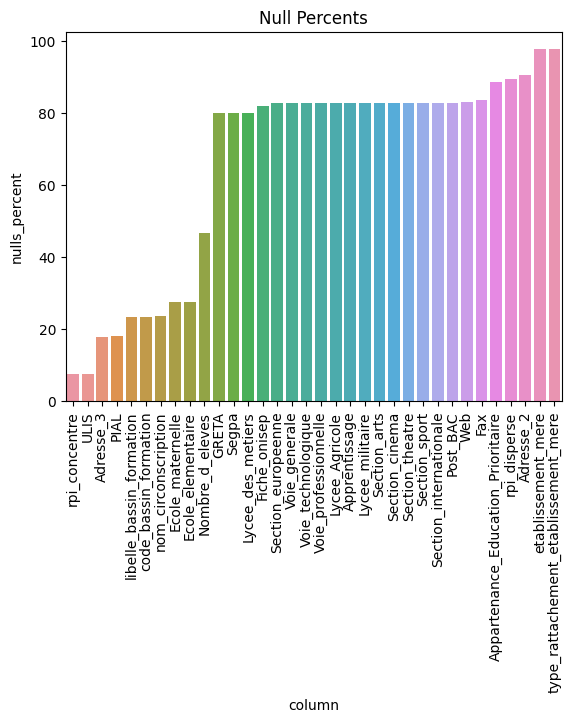

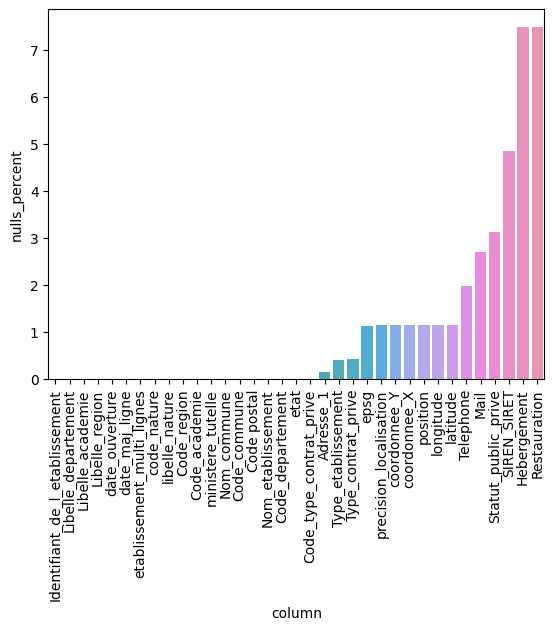

In [5]:
null_pct = education_directory_raw.isna().sum()*100/68977
plt.title('Null Percents')
null_pct = pd.DataFrame({'column':null_pct.index,'nulls_percent':null_pct.values}).sort_values(by='nulls_percent')
sns.barplot(data=null_pct.iloc[-34:,:], x='column',y='nulls_percent')
plt.xticks(rotation=90)
plt.show()
sns.barplot(data=null_pct.iloc[:35,:], x='column',y='nulls_percent')
plt.xticks(rotation=90)
plt.show()

And the distribution of the data with respect of the regions in France. I will be focusing in the Ile de France (Paris) region.

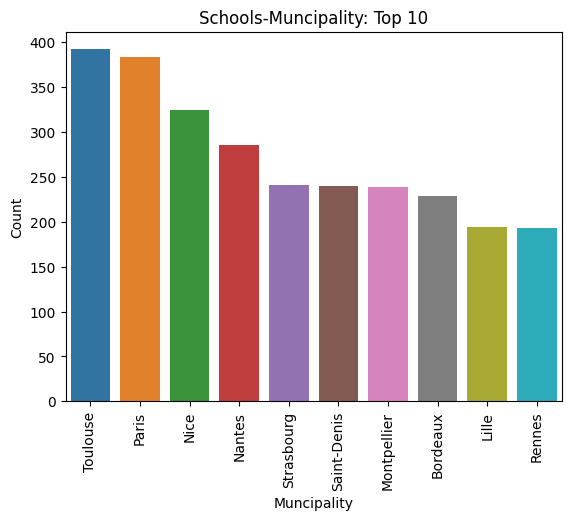

In [6]:
plt.title('Schools-Muncipality: Top 10')
ncom_counts = education_directory_raw['Nom_commune'].value_counts()
ncom_counts = pd.DataFrame({'Muncipality':ncom_counts.index[:10],'Count':ncom_counts.values[:10]})
sns.barplot(data=ncom_counts, x='Muncipality',y='Count', )
plt.xticks(rotation=90)
plt.show()

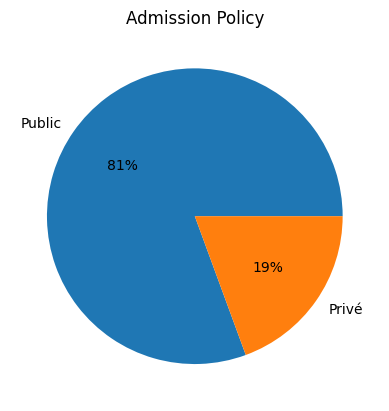

In [7]:
plt.title('Admission Policy')
plt.pie(
    x=education_directory_raw['Statut_public_prive'].value_counts(),
    labels=education_directory_raw['Statut_public_prive'].value_counts().index,
    autopct='%.0f%%',
    
)
plt.show()

The "ECOLE MATERNELLE D APPLICATION" nursery schools are those in which the teachers are trainers of other teachers' schools, in this schools new methods and pedagogies are used.

In [8]:
nursery_types_counts = education_directory_raw[education_directory_raw['libelle_nature'].str.contains('maternelle',case=False)]['libelle_nature'].value_counts()
nursery_types_counts = pd.DataFrame({'Type':nursery_types_counts.index,'Count':nursery_types_counts.values})
nursery_types_counts

,Type,Count
0,ECOLE MATERNELLE,13131
1,ECOLE MATERNELLE D APPLICATION,70
2,ECOLE MATERNELLE ANNEXE D INSPE,1


Here is a brief inspection of the housing data:

In [9]:
housing_data.columns

Index(['Année', 'Secteurs géographiques', 'Numéro du quartier',
       'Nom du quartier', 'Nombre de pièces principales',
       'Epoque de construction', 'Type de location', 'Loyers de référence',
       'Loyers de référence majorés', 'Loyers de référence minorés', 'Ville',
       'Numéro INSEE du quartier', 'geo_shape', 'geo_point_2d'],
      dtype='object')

In [10]:
housing_data.sample(3)

,Année,Secteurs géographiques,Numéro du quartier,Nom du quartier,Nombre de pièces principales,Epoque de construction,Type de location,Loyers de référence,Loyers de référence majorés,Loyers de référence minorés,Ville,Numéro INSEE du quartier,geo_shape,geo_point_2d
1475,2023,1,27,Ecole-Militaire,3,1946-1970,meublé,30.4,36.50,21.30,PARIS,7510727,"{""coordinates"": [[[2.3200836737076695, 48.8481...","48.850359261547545, 2.3110309362657624"
3159,2022,11,43,Roquette,4,Apres 1990,non meublé,19.4,23.28,13.58,PARIS,7511143,"{""coordinates"": [[[2.379720818886926, 48.85344...","48.85706404083103, 2.380364061726765"
6144,2020,4,9,Arts-et-Metiers,2,Avant 1946,meublé,31.3,37.56,21.91,PARIS,7510309,"{""coordinates"": [[[2.360209979547445, 48.86519...","48.86647028948417, 2.357083131056784"


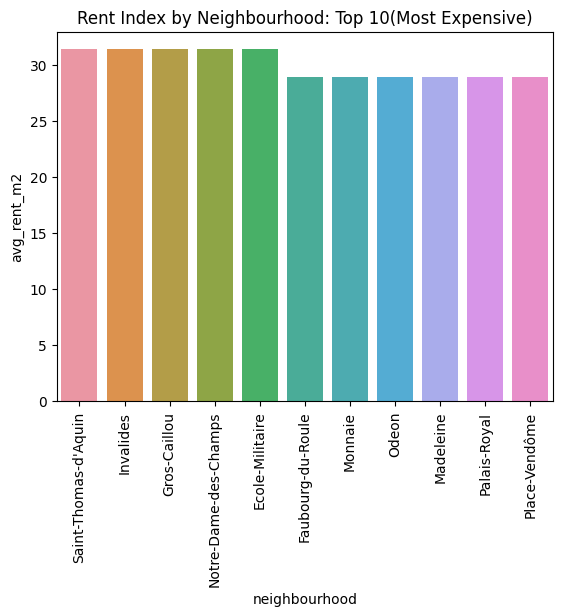

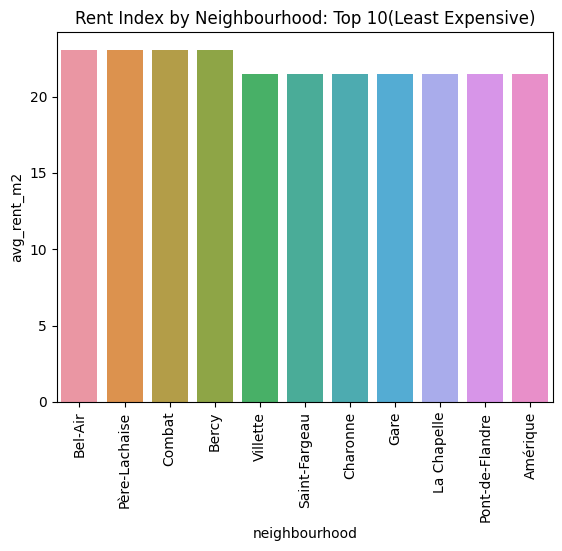

In [11]:
housing_data_2023 = housing_data[housing_data['Année'] == 2023]
rent_index_mean = housing_data_2023[
    ['Nom du quartier','Loyers de référence','Numéro du quartier']
].groupby(
    ['Nom du quartier']
).mean().sort_values(by='Loyers de référence', ascending=False)
rent_index_mean.rename(columns={'Nom du quartier': 'neighbourhood','Numéro du quartier':'neighbourhood_number','Loyers de référence':'rent_index'}, inplace=True)
rent_index_mean_data = pd.DataFrame({
    'neighbourhood': rent_index_mean.index, 
    'avg_rent_m2':rent_index_mean['rent_index'].values 
})
plt.title('Rent Index by Neighbourhood: Top 10(Most Expensive)')
sns.barplot(data=rent_index_mean_data.iloc[:11,:], x='neighbourhood', y='avg_rent_m2')
plt.xticks(rotation=90)
plt.show()
plt.title('Rent Index by Neighbourhood: Top 10(Least Expensive)')
sns.barplot(data=rent_index_mean_data.iloc[-11:,:], x='neighbourhood', y='avg_rent_m2')
plt.xticks(rotation=90)
plt.show()

I will also include the distance of each school to the closest subway or train station. I will call the google Places API. See details in the corresponding section below.

In [12]:
# Pre Processed Google Data, see code in pre-processing section
google_maps_public_transport_data.sample(5)

,index,name,closest_station_name,distance,id
195,15004,E.E.PU GENERAL CAMOU 1 rue du Général Camou,École Militaire,0.653448,0750846M
617,48778,E.M.PU RETRAIT 24 rue du Retrait,Laumière,2.073278,0751381U
33,7387,E.E.PU LEPIC 62 rue Lepic,Anvers,0.868042,0750923W
47,7401,E.E.PU ST ISAURE 18 rue Saint Isaure,Jules Joffrin,0.182071,0751008N
206,15026,E.E.PU PLAINE EA 11 rue de la Plaine,Porte de Montreuil,0.830904,0750967U


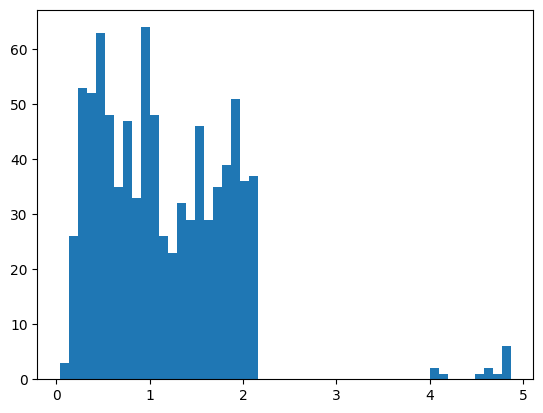

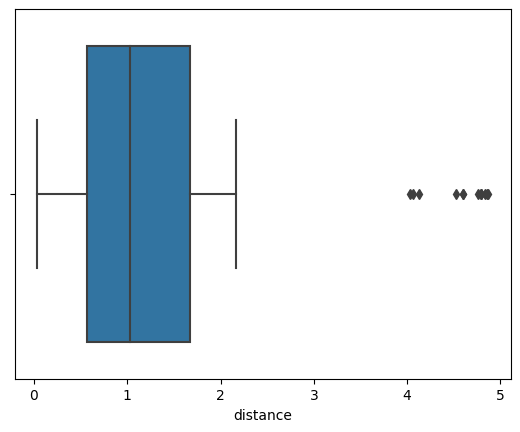

In [13]:
plt.hist(list(google_maps_public_transport_data['distance']), bins=50)
plt.show()
sns.boxplot(x=google_maps_public_transport_data['distance'])
plt.show()

This dataset contains the number of students and classes of each of the school for the data density information. From this dataset I will also include the REP and REP + information:
In the French education system, "REP" stands for "Réseau d'Éducation Prioritaire," which translates to "Priority Education Network." It refers to a group of schools located in socially disadvantaged areas that face specific challenges related to student performance and educational success. The goal of REP schools is to provide additional resources, support, and initiatives to help students overcome these challenges and improve their academic outcomes.

Similarly, "REP+" stands for "Réseau d'Éducation Prioritaire Renforcé," which translates to "Reinforced Priority Education Network." This designation indicates schools that are in even more challenging socio-economic contexts compared to regular REP schools. REP+ schools receive further support and resources to address the additional difficulties their students might face.

Both REP and REP+ schools aim to reduce educational inequalities and improve the educational experience and outcomes for students from disadvantaged backgrounds. They often implement specific programs, smaller class sizes, additional teaching resources, and various support measures to achieve these goals.

In [14]:
schools_density.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194898 entries, 0 to 194897
Data columns (total 23 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   Rentrée scolaire                              194898 non-null  int64 
 1   Région académique                             194898 non-null  object
 2   Académie                                      194898 non-null  object
 3   Département                                   194898 non-null  object
 4   Commune                                       194898 non-null  object
 5   Numéro de l'école                             194898 non-null  object
 6   Dénomination principale                       194897 non-null  object
 7   Patronyme                                     148531 non-null  object
 8   Secteur                                       194898 non-null  object
 9   REP                                           194898 non-nu

In [15]:
schools_density.sample(3)

,Rentrée scolaire,Région académique,Académie,Département,Commune,Numéro de l'école,Dénomination principale,Patronyme,Secteur,REP,...,Nombre d'élèves en pré-élémentaire hors ULIS,Nombre d'élèves en élémentaire hors ULIS,Nombre d'élèves en ULIS,Nombre d'élèves en CP hors ULIS,Nombre d'élèves en CE1 hors ULIS,Nombre d'élèves en CE2 hors ULIS,Nombre d'élèves en CM1 hors ULIS,Nombre d'élèves en CM2 hors ULIS,tri,Code Postal
41532,2022,OCCITANIE,TOULOUSE,HAUTES-PYRENEES,BERNAC-DEBAT,0650384P,ECOLE PRIMAIRE PUBLIQUE,NaN,PUBLIC,0,...,35,31,0,7,13,11,0,0,78-OCCITANIE-TOULOUSE-HAUTES-PYRENEES-BERNAC-D...,65360
95929,2021,PROVENCE-ALPES-COTE-D'AZUR,NICE,ALPES-MARITIMES,MENTON,0061270Y,ECOLE MATERNELLE PUBLIQUE,DEBRE MAT,PUBLIC,0,...,111,0,0,0,0,0,0,0,79-PROVENCE-ALPES-COTE-D'AZUR-NICE-ALPES-MARIT...,6500
146663,2019,AUVERGNE-ET-RHONE-ALPES,CLERMONT-FERRAND,PUY-DE-DOME,CLERMONT-FERRAND,0631587H,ECOLE MATERNELLE PUBLIQUE,PHILIPPE ARBOS,PUBLIC,0,...,109,0,0,0,0,0,0,0,81-AUVERGNE-ET-RHONE-ALPES-CLERMONT-FERRAND-PU...,63100


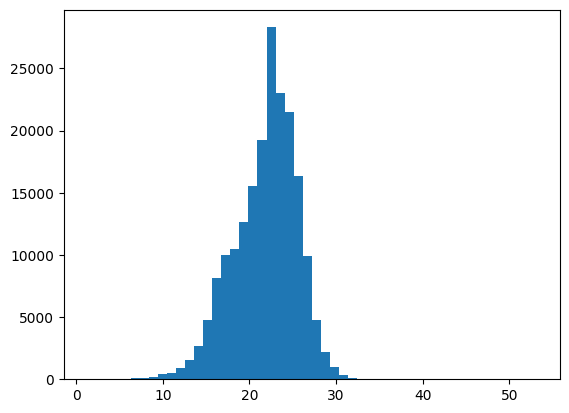

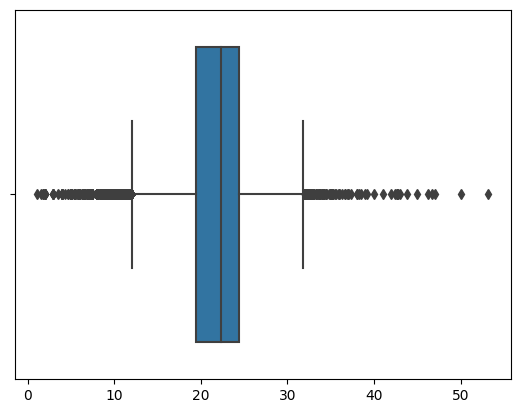

In [16]:
# Student Density = Total number of students/Classes
plt.hist(list(schools_density["Nombre total d'élèves"]/schools_density['Nombre total de classes']), bins=50)
plt.show()
sns.boxplot(x=list(schools_density["Nombre total d'élèves"]/schools_density['Nombre total de classes']))
plt.show()

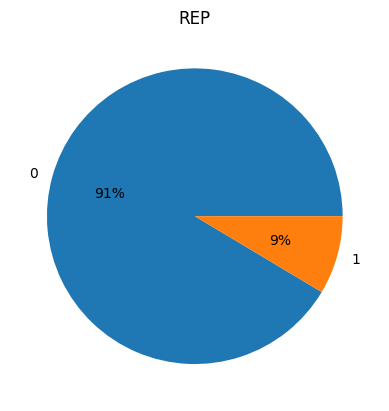

In [17]:
plt.title('REP')
plt.pie(
    x=schools_density['REP'].value_counts(),
    labels=schools_density['REP'].value_counts().index,
    autopct='%.0f%%',
    
)
plt.show()

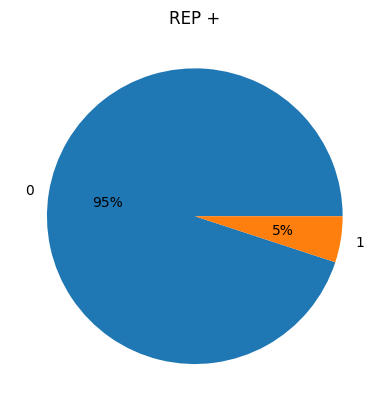

In [18]:
plt.title('REP +')
plt.pie(
    x=schools_density['REP +'].value_counts(),
    labels=schools_density['REP +'].value_counts().index,
    autopct='%.0f%%',
    
)
plt.show()

## Data Pre-Processing

In [19]:
#CONSTANTS
GOOGLE_MAPS_ENDPOINT = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json?'
G_API_KEY = None

with open('./api_keys/keys.json','r') as file:
    G_API_KEY = json.loads(file.read())['g']

#HELPERS
def get_distance(lat_long_a: tuple, lat_long_b: tuple):
        return geodesic(lat_long_a, lat_long_b).km

#CLASSES
class Station:
    def __init__(self, name, lat, long, radius=5000):
        self.name = name
        self.lat = lat
        self.long = long
        self.radius = radius
        self.stations = None
        self.closest_station = None
        self.closest_station_name = None
        self.closest_distance = None
        self.call_google()
        
    
    
    def call_google(self):
        url = f'{GOOGLE_MAPS_ENDPOINT}location={self.lat}%2C{self.long}&radius={self.radius}&type=subway_station|train_station&key={G_API_KEY}'
        payload={}
        headers = {}
        response = json.loads(requests.request("GET", url, headers=headers, data=payload).text)
        self.stations = response['results']
        if (len(self.stations)):
            try:
                self.closest_station = self.stations[0]
                location = self.closest_station['geometry']['location']
                self.closest_distance = get_distance((self.lat, self.long),(location['lat'], location['lng']))
                self.closest_station_name = self.stations[0]['name']
            except Exception as e:
                print(f'Error getting dictance {e}')
# Filter Paris Region, School Types
class Drop_Columns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop: list = None) -> None:
        self.X = None
        self.y = None
        self.columns_to_drop = columns_to_drop

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None) -> None:
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.X.drop(columns=self.columns_to_drop) if self.columns_to_drop else self.X

class Rename_Columns(BaseEstimator, TransformerMixin):
    def __init__(self, column_name_map: dict = None) -> None:
        self.X = None
        self.y = None
        self.column_name_map = column_name_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None) -> None:
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.X.rename(columns=self.column_name_map) if self.column_name_map else self.X

class Set_Data_Types(BaseEstimator, TransformerMixin):
    def __init__(self, column_type_map) -> None:
        self.X = None
        self.y = None
        self.column_type_map = column_type_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None) -> None:
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.X.astype(self.column_type_map) if self.column_type_map else self.X

class Basic_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop: list = None, column_name_map: dict = None, column_type_map: dict = None) -> None:
        self.X = None
        self.y = None
        self.columns_to_drop = columns_to_drop
        self.column_name_map = column_name_map
        self.column_type_map = column_type_map

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        self.X = X
        self.y = y
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return Pipeline([
            ('drop_columns', Drop_Columns(self.columns_to_drop)),
            ('rename_columns', Rename_Columns(self.column_name_map)),
            ('set_data_types', Set_Data_Types(self.column_type_map))
        ]).fit_transform(X=self.X, y=self.y)


I will make a first join of the school density and education directory.

In [20]:
education_directory_raw_copy = education_directory_raw.rename(columns={"Identifiant_de_l_etablissement":'id'},inplace=False)
education_directory_raw_copy = education_directory_raw_copy.set_index(keys=['id'],inplace=False)
schools_density_copy = schools_density.rename(columns={"Numéro de l'école":"id"},inplace=False)
schools_density_copy = schools_density_copy.set_index(keys=['id'],inplace=False)
schools_density_copy = schools_density_copy[schools_density_copy['Rentrée scolaire']==2022]
education_dir_w_density = pd.merge(education_directory_raw_copy,schools_density_copy,on='id',how='inner')
education_dir_w_density.sample(3)

,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code postal,Code_commune,Nom_commune,Code_departement,...,Nombre d'élèves en pré-élémentaire hors ULIS,Nombre d'élèves en élémentaire hors ULIS,Nombre d'élèves en ULIS,Nombre d'élèves en CP hors ULIS,Nombre d'élèves en CE1 hors ULIS,Nombre d'élèves en CE2 hors ULIS,Nombre d'élèves en CM1 hors ULIS,Nombre d'élèves en CM2 hors ULIS,tri,Code Postal
id,,,,,,,,,,,,,,,,,,,,,
0592196S,Ecole primaire,Ecole,Public,8 rue Théodore Fontaine,NaN,59330 ST REMY DU NORD,59330,59543,Saint-Remy-du-Nord,059,...,36,61,0,11,16,15,9,10,78-HAUTS-DE-FRANCE-LILLE-NORD-SAINT-REMY-DU-NO...,59330
0140238H,Ecole primaire,Ecole,Public,36 rue GRANDE,NaN,14470 GRAYE SUR MER,14470,14318,Graye-sur-Mer,014,...,46,84,0,18,11,24,12,19,78-NORMANDIE-CAEN-CALVADOS-GRAYE-SUR-MER-0140238H,14470
7200646P,Ecole maternelle U PETRICCIU Cervione,Ecole,Public,Village U Casone U PETRICCIU,NaN,20221 CERVIONE,20221,2B087,Cervione,02B,...,44,0,0,0,0,0,0,0,78-CORSE-CORSE-HAUTE-CORSE-CERVIONE-7200646P,20221


I will focus my analysis on the area of Paris and elementary/primary education data, since it is my main interest. I will also drop 3 schools without geolocation info.

In [21]:
df_filter = (education_dir_w_density['Type_etablissement'] == 'Ecole') & \
(((education_dir_w_density['Code postal'] == 78100) | (education_dir_w_density['Code postal'] == 78112)) | \
((education_dir_w_density['Code postal'] >= 75000) & (education_dir_w_density['Code postal'] < 76000)))
paris_school_data = education_dir_w_density[df_filter]
paris_school_data = paris_school_data.rename(columns={"Identifiant_de_l_etablissement":"id"})
paris_school_data = paris_school_data.drop(paris_school_data[paris_school_data['longitude'].isna()].index)
paris_school_data = paris_school_data.reset_index()
paris_school_data.sample(3)

,id,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code postal,Code_commune,Nom_commune,...,Nombre d'élèves en pré-élémentaire hors ULIS,Nombre d'élèves en élémentaire hors ULIS,Nombre d'élèves en ULIS,Nombre d'élèves en CP hors ULIS,Nombre d'élèves en CE1 hors ULIS,Nombre d'élèves en CE2 hors ULIS,Nombre d'élèves en CM1 hors ULIS,Nombre d'élèves en CM2 hors ULIS,tri,Code Postal
349,0751114D,E.E.PU RAMPAL 11 rue Rampal,Ecole,Public,11 rue Rampal,NaN,75019 PARIS,75019,75119,Paris 19e Arrondissement,...,0,188,0,32,40,40,39,37,78-ILE-DE-FRANCE-PARIS-PARIS-PARIS 19E ARROND...,75019
10,0750234X,E.P.PR EUGENE NAPOLEON ST P. FOURIER 252 ter r...,Ecole,Privé,252 ter rue du Faubourg Saint-Antoine,NaN,75012 PARIS,75012,75112,Paris 12e Arrondissement,...,155,361,12,62,72,66,74,87,78-ILE-DE-FRANCE-PARIS-PARIS-PARIS 12E ARROND...,75012
601,0755471P,E.P.PR SAINT JEAN 89 rue Olivier de Serres,Ecole,Privé,89 rue Olivier de Serres,NaN,75015 PARIS,75015,75115,Paris 15e Arrondissement,...,88,255,0,46,50,53,53,53,78-ILE-DE-FRANCE-PARIS-PARIS-PARIS 15E ARROND...,75015


Detect through schools

In [22]:
paris_school_data['is_through_school'] = paris_school_data['Adresse_1'].duplicated(keep=False)
paris_school_data = paris_school_data[paris_school_data['Dénomination principale'].str.contains('MATERNELLE')]
paris_school_data.sample(3)

,id,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code postal,Code_commune,Nom_commune,...,Nombre d'élèves en élémentaire hors ULIS,Nombre d'élèves en ULIS,Nombre d'élèves en CP hors ULIS,Nombre d'élèves en CE1 hors ULIS,Nombre d'élèves en CE2 hors ULIS,Nombre d'élèves en CM1 hors ULIS,Nombre d'élèves en CM2 hors ULIS,tri,Code Postal,is_through_school
567,0751435C,E.M.PU BRETONNEAU C 12 rue Bretonneau,Ecole,Public,12 rue Bretonneau,NaN,75020 PARIS,75020,75120,Paris 20e Arrondissement,...,0,0,0,0,0,0,0,78-ILE-DE-FRANCE-PARIS-PARIS-PARIS 20E ARROND...,75020,False
135,0753580J,E.M.A.PU LOUIS VIERNE 4 rue Louis Vierne,Ecole,Public,4 rue Louis Vierne,NaN,75017 PARIS,75017,75117,Paris 17e Arrondissement,...,0,0,0,0,0,0,0,78-ILE-DE-FRANCE-PARIS-PARIS-PARIS 17E ARROND...,75017,False
248,0751727V,E.M.PU CAMBRAI 5 bis rue Cambrai,Ecole,Public,5 bis rue de Cambrai,NaN,75019 PARIS,75019,75119,Paris 19e Arrondissement,...,0,0,0,0,0,0,0,78-ILE-DE-FRANCE-PARIS-PARIS-PARIS 19E ARROND...,75019,False


#### Assigning Quartier to Paris Schools
We will need to join the housing data with the education directory data as part of pre-processing. Since we don't have a direct relation between the two dataframes we will need to calculate if the latitudes and longitudes of each school (in Paris) is within the polygons in the paris neighbourhoods data set, and insert this information to the education directory dataframe using the shapely package.

In [23]:
school_quartier_pointer = namedtuple("SchoolPointer", "school_id quartier_id quartier_name")
paris_neighbourhoods_geometry = paris_neighbourhoods[['Geometry']]['Geometry'].apply(lambda c: np.array(json.loads(c)['coordinates'][0]))
paris_neighbourhoods_polygons = [Polygon(np.array([polygons.T[1],polygons.T[0]]).T) for polygons in paris_neighbourhoods_geometry]

paris_schools_geolocation = paris_school_data.iloc[:,[0,51,52]]
paris_schools_points = [(id_, Point(lat, long)) for (id_, lat,long) in np.array(paris_schools_geolocation)]


paris_schools_quartiers_pointers = []
for school_id, point in paris_schools_points:
    match = False
    for idx_polygon, polygon in enumerate(paris_neighbourhoods_polygons):
        is_within = point.within(polygon)
        if(is_within):
            q_id, q_name = tuple(paris_neighbourhoods.iloc[idx_polygon,[1,3]].values)
            paris_schools_quartiers_pointers.append(school_quartier_pointer(school_id, q_id, q_name))
            match = True
    if(not match):
        paris_schools_quartiers_pointers.append(school_quartier_pointer(school_id, -1, 'Saint-Germain-en-Laye'))
paris_schools_quartiers_pointers[:3]

[SchoolPointer(school_id='0751247Y', quartier_id=70, quartier_name='Clignancourt'),
 SchoolPointer(school_id='0751248Z', quartier_id=68, quartier_name='Epinettes'),
 SchoolPointer(school_id='0751250B', quartier_id=55, quartier_name='Petit-Montrouge')]

#### Public Transport Options of the Area

We will use the Google Maps API to get the nearest subway or train station in KM to each Paris' school in the education directory.
The code in this section is commented, so we don't call Google's API's on every notebook run, but the data is saved as csv.

In [24]:
school_geo_location = namedtuple('Geolocation','name lat long')
schools_public_transport_info = []
schools_geolocs = [school_geo_location(school[0], school[1], school[2]) for school in list(paris_school_data[['Nom_etablissement','latitude','longitude']].values)]
for school in schools_geolocs:
    try:
        #station = Station(school.name, school.lat, school.long)
        #schools_public_transport_info.append(station)
        pass
    except Exception as e:
        print(e)

In [25]:
#schools_public_transport_summary = pd.DataFrame(
#    [np.array([s.name, s.closest_station_name, s.closest_distance]) for s in schools_public_transport_info], 
#    columns=['name', 'closest_station_name','distance'],
#    index = paris_school_data.index
#)
#schools_public_transport_summary['id'] = list(paris_school_data['id'].values)
#schools_public_transport_summary
#schools_public_transport_summary.to_csv('./data/paris_opendata/paris_schools_public_transport_info.csv')
google_maps_public_transport_data.sample(5)

,index,name,closest_station_name,distance,id
582,48743,E.P.PU PIERRE FONCIN EB 4 rue Pierre Foncin,Porte de Montreuil,1.968784,0751178Y
715,62444,E.E.PU DAMREMONT EA 67 rue Damrémont,Lamarck - Caulaincourt,0.372850,0750865H
795,62524,E.M.PU EMILE LEPEU 44 rue Emile Lepeu,Porte de Montreuil,1.663118,0752403E
342,21754,E.P.PR L'ASSOMPTION 6 rue de Lubeck,Kléber,0.534434,0750295N
321,15208,Ecole primaire Le cours du rocher,Courcelles,0.349591,0756038F


Now let's merge all our data into a single data frame. I will set the average rent price as the median for "Saint Gemrain en Laye" since it's outside of Paris, and actually, it looks like it isn't far from the actual prices (https://immobilier.lefigaro.fr/prix-immobilier/saint-germain-en-laye/ville-78551#loyer-m2)

In [26]:
paris_school_data_ = paris_school_data.copy()
public_transport_data = google_maps_public_transport_data.copy()
df_raw = pd.merge(paris_school_data_,public_transport_data, on='id', how='inner')
paris_schools_neighbourhoods = pd.DataFrame(paris_schools_quartiers_pointers, 
    columns=['id','neighbourhood_number','neighbourhood_name']
)
df_raw = pd.merge(df_raw, paris_schools_neighbourhoods, on='id', how='inner')
df_raw = pd.merge(df_raw, rent_index_mean, on='neighbourhood_number', how='left')
df_raw['rent_index'] = df_raw['rent_index'].fillna(df_raw['rent_index'].mean())
df_raw['age'] = (datetime.now()-pd.to_datetime(df_raw['date_ouverture'])).apply(lambda d: d.total_seconds()/3.154e+7)
df_raw['density'] = df_raw["Nombre total d'élèves"]/df_raw['Nombre total de classes']
df_raw.sample(3)

,id,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code postal,Code_commune,Nom_commune,...,is_through_school,index,name,closest_station_name,distance,neighbourhood_number,neighbourhood_name,rent_index,age,density
209,0752566G,E.M.PU CHATEAU DES RENTIERS G 103 rue du Châte...,Ecole,Public,103 rue du Château des Rentiers,NaN,75013 PARIS,75013,75113,Paris 13e Arrondissement,...,False,48796,E.M.PU CHATEAU DES RENTIERS G 103 rue du Châte...,Austerlitz,1.511999,50,Gare,21.478125,46.225629,17.8
48,0754310C,E.M.PU DARIUS MILHAUD 53 allée Darius Milhaud,Ecole,Public,53 allée Darius Milhaud,NaN,75019 PARIS,75019,75119,Paris 19e Arrondissement,...,False,7493,E.M.PU DARIUS MILHAUD 53 allée Darius Milhaud,Laumière,0.827803,75,Amérique,21.478125,33.988825,19.9
30,0751417H,E.M.A.PU VANDREZANNE H 40 rue Vandrezanne,Ecole,Public,40 rue Vandrezanne,NaN,75013 PARIS,75013,75113,Paris 13e Arrondissement,...,False,7455,E.M.A.PU VANDREZANNE H 40 rue Vandrezanne,Austerlitz,1.814359,51,Maison-Blanche,25.156250,58.339161,16.0


And let's rename columns, set data types and drop columns that we will not be using:

In [27]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Columns: 101 entries, id to density
dtypes: bool(1), float64(31), int64(21), object(48)
memory usage: 230.9+ KB


In [28]:
df_cleaner = Basic_Transformer(columns_to_drop=[
    'Adresse_2',
    'Adresse_3',
    'Code_departement',
    'Code_academie',
    'Code_region',
    'Ecole_maternelle',
    'Ecole_elementaire',
    'Voie_generale',
    'Voie_technologique',
    'Voie_professionnelle',
    'Telephone',
    'Fax',
    'Web',
    'Mail',
    'Libelle_academie',
    'Libelle_region',
    'Apprentissage',
    'Segpa',
    'Lycee_Agricole',
    'Lycee_militaire',
    'Lycee_des_metiers',
    'Post_BAC',
    'GRETA',
    'SIREN_SIRET',
    'Fiche_onisep',
    'position',
    'coordonnee_X',
    'coordonnee_Y',
    'epsg',
    'nom_circonscription',
    'precision_localisation',
    'ministere_tutelle',
    'rpi_concentre',
    'rpi_disperse',
    'code_nature',
    'libelle_nature',
    'PIAL',
    'etablissement_mere',
    'type_rattachement_etablissement_mere',
    'code_bassin_formation',
    'libelle_bassin_formation',
    'Nombre_d_eleves',
    'Type_contrat_prive',
    'Code_type_contrat_prive',
    "Nombre d'élèves en pré-élémentaire hors ULIS",
    "Nombre d'élèves en élémentaire hors ULIS", 
    "Nombre d'élèves en ULIS",
    "Nombre d'élèves en CP hors ULIS", 
    "Nombre d'élèves en CE1 hors ULIS",
    "Nombre d'élèves en CE2 hors ULIS", 
    "Nombre d'élèves en CM1 hors ULIS",
    "Nombre d'élèves en CM2 hors ULIS",
    'tri', 
    'latitude', 
    'longitude',
    'date_ouverture',
    'date_maj_ligne',
    'Rentrée scolaire',
    'Région académique',
    'Académie',
    'Département',
    'Patronyme',
    'Nombre total de classes',
    "Nombre total d'élèves",
    'Libelle_departement'],
    column_name_map={
        'Identifiant_de_l_etablissement': 'uai',
        'Nom_etablissement': 'institution_name',
        'Type_etablissement': 'institution_type',
        'Statut_public_prive': 'public_private_status',
        'Adresse_1': 'address',
        'Code postal': 'zip_code',
        'Code_commune': 'municipality_code',
        'Nom_commune': 'municipality_name',
        'Restauration': 'has_catering_service',
        'Hebergement': 'has_lodging_service',
        'ULIS': 'has_inclusive_education',
        'etat': 'institution_status',
        'etablissement_multi_lignes': 'is_multi_uai',
        'Dénomination principale':'main_denomination'
    },
    column_type_map={
        'institution_type': 'category',
        'public_private_status': 'category',
        'institution_type': 'category',
        'public_private_status': 'category',
        'zip_code': 'int32',
        'municipality_code': 'category',
        'municipality_name': 'category',
        'has_catering_service': 'bool',
        'has_lodging_service': 'bool',
        'has_inclusive_education': 'bool',
        'institution_status': 'category',
        'is_multi_uai': 'bool',
        'main_denomination':'category'
                    })

Then I will prepare the data to run the PCA and K-Mode-Prototype algorithms with it. PCA needs all numeric data and KMP accepts both numerical and non-numerical data. I want to use the PCA algorith to get the most important features in the dataset and then the KMP to cluster similar schools together.

In [29]:
main_denomination_encoder = LabelEncoder()
std_scaler = StandardScaler()
df_analysis: pd.DataFrame = df_cleaner.fit_transform(X=df_raw)[[
    'public_private_status',
    'has_catering_service',
    'has_lodging_service',
    'has_inclusive_education',
    'main_denomination',
    'REP',
    'REP +',
    'distance',
    'rent_index',
    'age',
    'density'
]]
main_denomination_encoded = main_denomination_encoder.fit_transform(df_analysis.main_denomination)
df_analysis_pca = df_analysis.assign(
    public_private_status=lambda df_:(df_.public_private_status == 'Public').astype('int'),
    has_catering_service=lambda df_:df_.has_catering_service.astype('int'),
    has_lodging_service=lambda df_:df_.has_lodging_service.astype('int'),
    has_inclusive_education=lambda df_:df_.has_inclusive_education.astype('int'),
    main_denomination=main_denomination_encoded
)
df_analysis = df_analysis.assign(
    has_catering_service=lambda df_:df_.has_catering_service.astype('int'),
    has_lodging_service=lambda df_:df_.has_lodging_service.astype('int'),
    has_inclusive_education=lambda df_:df_.has_inclusive_education.astype('int')
)
df_analysis.sample(5)

,public_private_status,has_catering_service,has_lodging_service,has_inclusive_education,main_denomination,REP,REP +,distance,rent_index,age,density
208,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,1,0,2.124710,21.478125,46.225629,22.166667
51,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,0,1,0.995584,24.637500,27.986846,15.714286
202,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,0,0,1.891460,25.156250,58.339161,23.000000
118,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,0,0,1.954627,25.156250,58.339161,20.200000
84,Public,1,0,0,ECOLE MATERNELLE D APPLICATION,0,0,2.093984,26.271875,58.339161,18.375000


## Analysis and Model

#### Categorical data selected for Analysis
1) public_private_status
2) has_catering_service
3) has_lodging_service
4) has_inclusive_education
5) main_denomination
6) REP
7) REP +

#### Numerical data selected for Analysis
1) Closest station distance
2) rent_index
3) age
4) density

Let's use the PCA algorithm to check wich variables are the most significative. I will set a 99% explained variance target.

In [30]:
pca_model = None
df_compressed = None
target_explained_var = 0.99
emplained_var = 0
for no_feautures in range(1,5):
    try:
        pca_model = PCA(no_feautures)
        tmp = pca_model.fit_transform(df_analysis_pca)
        explained_var = pca_model.explained_variance_ratio_.sum()
        print(explained_var)
        if(explained_var >= target_explained_var):
            df_compressed = tmp
            break;
    except Exception as e:
        print(e)

0.8882591238235918
0.9698770249706931
0.9946669797669658


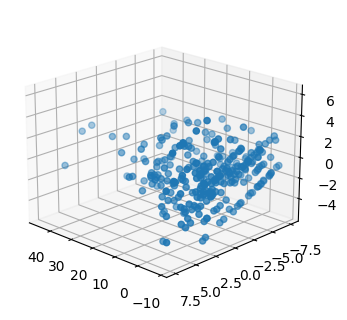

In [31]:
df_compressed_plot = pd.DataFrame(df_compressed, columns=['D1','D2','D3'])
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = fig.add_subplot(111, projection="3d", elev=20, azim=134)
ax.set_position([0, 0, 0.98, 1])
plt.cla()
ax.scatter(df_compressed_plot['D1'], df_compressed_plot['D2'], df_compressed_plot['D3'])
plt.show()

In [32]:
df_analysis_pca

,public_private_status,has_catering_service,has_lodging_service,has_inclusive_education,main_denomination,REP,REP +,distance,rent_index,age,density
0,1,1,0,0,2,1,0,0.200021,24.121875,58.339161,16.000000
1,1,1,0,0,2,1,0,1.042664,24.637500,58.339161,14.750000
2,1,1,0,0,2,0,0,1.069267,25.728125,58.339161,21.800000
3,1,1,0,0,2,0,0,0.676457,24.637500,58.339161,18.750000
4,1,1,0,0,2,0,0,0.324103,25.728125,58.339161,25.500000
...,...,...,...,...,...,...,...,...,...,...,...
290,1,1,0,0,2,0,0,4.795224,24.658132,52.276916,19.000000
291,1,1,0,0,2,0,0,4.762391,24.658132,47.937740,20.000000
292,1,0,0,0,2,0,0,4.066824,24.658132,43.962902,24.666667
293,1,1,0,0,2,0,0,4.596927,24.658132,58.339161,29.000000


In [33]:
pd.DataFrame(pca_model.components_,columns=df_analysis_pca.columns,index = ['PC-1','PC-2','PC-3'])

,public_private_status,has_catering_service,has_lodging_service,has_inclusive_education,main_denomination,REP,REP +,distance,rent_index,age,density
PC-1,-0.000868,-0.003669,-1.387779e-17,-4.336809e-19,-0.002047,-0.000767,-0.000457,-0.000272,-0.030818,-0.999382,-0.016325
PC-2,-0.000215,-0.006227,-8.326673e-17,0.000000e+00,0.004154,-0.086128,-0.017555,-0.008721,0.387364,-0.026838,0.917262
PC-3,0.002394,-0.000828,2.220446e-16,-4.163336e-17,-0.012090,-0.021620,0.010733,-0.085195,0.916154,-0.021818,-0.390119


In [34]:
df_analysis_matrix = df_analysis.to_numpy()
df_analysis_matrix.shape

(295, 11)

The age, rent index and denisty seem to have a lot of importance.

I will use the k-modes prototypes algorithm for clustering the data. Since I want to know the similarity between schools. I will use this algorithm which is specifically designed for mixed non-categorical and categorical data. The traditional k-means algorithm is used for continuous numerical data, and k-modes for categorical data. The K-Modes Prototype algorithm extends this concept to handle a mix of numerical and categorical data.
Then I will use the elbow method to check the optimal number of clusters for the algorith using it's cost function.

1 clusters.
2 clusters.
3 clusters.
4 clusters.
5 clusters.
6 clusters.
7 clusters.
8 clusters.
9 clusters.


<function matplotlib.pyplot.show(close=None, block=None)>

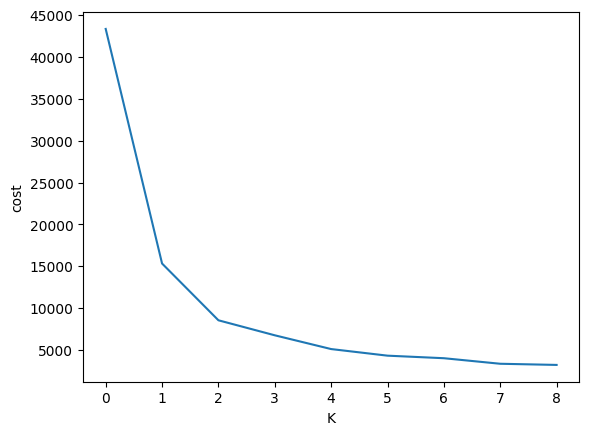

In [35]:
cost = []
for clusters in range(1,10):
    try:
        kproto = KPrototypes(n_clusters=clusters, max_iter=20)
        kproto.fit_predict(df_analysis_matrix, categorical=[0,1,2,3,4,5,6])
        cost.append(kproto.cost_)
        print(f'{clusters} clusters.')
    except Exception as e:
        print(e)
plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [36]:
kproto = KPrototypes(n_clusters=3, max_iter=20)
labels = kproto.fit_predict(df_analysis_matrix, categorical=[0,1,2,3,4,5,6])
df_analysis['label'] = labels
df_analysis['latitude'] = df_raw['latitude'] 
df_analysis['longitude']= df_raw['longitude']
df_analysis['school_name']= df_raw['Nom_etablissement']

### Results and comparisson

In [37]:
df_analysis

,public_private_status,has_catering_service,has_lodging_service,has_inclusive_education,main_denomination,REP,REP +,distance,rent_index,age,density,label,latitude,longitude,school_name
0,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,1,0,0.200021,24.121875,58.339161,16.000000,1,48.894618,2.350401,E.M.PU AMIRAUX 19 rue des Amiraux
1,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,1,0,1.042664,24.637500,58.339161,14.750000,1,48.898859,2.326848,E.M.PU ANDRE BRECHET 21 rue André Brechet
2,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,0,0,1.069267,25.728125,58.339161,21.800000,1,48.827282,2.322534,E.M.PU CHANTIN 22 rue Antoine Chantin
3,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,0,0,0.676457,24.637500,58.339161,18.750000,1,48.842607,2.375239,E.M.PU BERCY N 167 rue de Bercy
4,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,0,0,0.324103,25.728125,58.339161,25.500000,1,48.842547,2.361867,E.M.PU BUFFON 15 bis rue Buffon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,0,0,4.795224,24.658132,52.276916,19.000000,1,48.896240,2.075476,Ecole maternelle Marcel Aymé
291,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,0,0,4.762391,24.658132,47.937740,20.000000,2,48.892990,2.064831,Ecole maternelle Beethoven
292,Public,0,0,0,ECOLE MATERNELLE PUBLIQUE,0,0,4.066824,24.658132,43.962902,24.666667,2,48.901126,2.068536,Ecole maternelle Passy
293,Public,1,0,0,ECOLE MATERNELLE PUBLIQUE,0,0,4.596927,24.658132,58.339161,29.000000,1,48.900927,2.080686,Ecole maternelle Ampère


I will use a map to display the result's with the resulting cluster label as a separate layer in the map.

In [47]:
m = folium.Map(location=[48.85422002028079, 2.3484716894925914], zoom_start=12)
feature_group_0 = folium.FeatureGroup(name='Label 0')
feature_group_1 = folium.FeatureGroup(name='Label 1')
feature_group_2 = folium.FeatureGroup(name='Label 2')

for latitude, longitude, school_name, label in zip(
    df_analysis.latitude.values, 
    df_analysis.longitude.values, 
    df_analysis.school_name.values,
    df_analysis.label
):
    icon = folium.Icon(
        color='blue' if label==0 else 'green' if label == 1 else 'purple',
        icon='school',
        prefix='fa'
    )
    mk = folium.Marker(
        location=(latitude, longitude),
        tooltip=school_name,
        popup=label,
        icon=icon
    )
    if label == 0:
        feature_group_0.add_child(mk)
    if label == 1:
        feature_group_1.add_child(mk)
    if label == 2:
        feature_group_2.add_child(mk)
m.add_child(feature_group_0)
m.add_child(feature_group_1)
m.add_child(feature_group_2)
m.add_child(folium.LayerControl())

m

Now let's take a look of each of the resulting clusters column's information.

In [39]:
df_analysis[df_analysis['label']==0].describe()

,has_catering_service,has_lodging_service,has_inclusive_education,REP,REP +,distance,rent_index,age,density,label,latitude,longitude
count,21.000000,21.0,21.0,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0,21.000000,21.000000
mean,0.904762,0.0,0.0,0.190476,0.047619,1.105079,24.122113,21.518260,20.282848,0.0,48.879976,2.345224
std,0.300793,0.0,0.0,0.402374,0.218218,0.907164,1.665431,8.313989,2.708651,0.0,0.016587,0.067328
min,0.000000,0.0,0.0,0.000000,0.000000,0.329667,21.478125,3.973454,15.250000,0.0,48.833703,2.070564
25%,1.000000,0.0,0.0,0.000000,0.000000,0.567659,23.062500,16.980023,18.600000,0.0,48.877009,2.339060
50%,1.000000,0.0,0.0,0.000000,0.000000,0.917089,24.121875,22.982002,21.200000,0.0,48.882260,2.355140
75%,1.000000,0.0,0.0,0.000000,0.000000,1.178053,25.728125,27.986846,21.823529,0.0,48.889900,2.378711
max,1.000000,0.0,0.0,1.000000,1.000000,4.521117,26.237500,30.986466,25.250000,0.0,48.897187,2.405538


In [40]:
df_analysis[df_analysis['label']==1].describe()

,has_catering_service,has_lodging_service,has_inclusive_education,REP,REP +,distance,rent_index,age,density,label,latitude,longitude
count,180.0,180.0,180.0,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.0,180.000000,180.000000
mean,1.0,0.0,0.0,0.261111,0.050000,1.199383,24.964212,57.969482,20.813727,1.0,48.860673,2.341640
std,0.0,0.0,0.0,0.440466,0.218553,0.748879,2.297872,1.423794,3.311086,0.0,0.022518,0.061640
min,1.0,0.0,0.0,0.000000,0.000000,0.077904,21.478125,50.203206,14.000000,1.0,48.821185,2.070915
25%,1.0,0.0,0.0,0.000000,0.000000,0.602625,24.121875,58.339161,17.901786,1.0,48.841990,2.319480
50%,1.0,0.0,0.0,0.000000,0.000000,1.092308,24.637500,58.339161,21.071429,1.0,48.858526,2.351596
75%,1.0,0.0,0.0,1.000000,0.000000,1.708678,26.237500,58.339161,23.270833,1.0,48.879380,2.381912
max,1.0,0.0,0.0,1.000000,1.000000,4.870546,31.431250,58.339161,29.000000,1.0,48.900990,2.413005


In [41]:
df_analysis[df_analysis['label']==2].describe()

,has_catering_service,has_lodging_service,has_inclusive_education,REP,REP +,distance,rent_index,age,density,label,latitude,longitude
count,94.000000,94.0,94.0,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.0,94.000000,94.000000
mean,0.957447,0.0,0.0,0.287234,0.031915,1.265954,24.191769,41.842040,20.441198,2.0,48.861665,2.340377
std,0.202930,0.0,0.0,0.454898,0.176716,0.742392,2.128412,4.481839,3.309286,0.0,0.023963,0.067429
min,0.000000,0.0,0.0,0.000000,0.000000,0.155108,21.478125,33.988825,13.000000,2.0,48.820577,2.064831
25%,1.000000,0.0,0.0,0.000000,0.000000,0.785551,21.478125,37.991057,17.438889,2.0,48.841816,2.313740
50%,1.000000,0.0,0.0,0.000000,0.000000,1.143679,24.637500,42.993162,20.729167,2.0,48.859755,2.364372
75%,1.000000,0.0,0.0,1.000000,0.000000,1.688577,25.728125,45.435318,23.200000,2.0,48.886328,2.380181
max,1.000000,0.0,0.0,1.000000,1.000000,4.762391,28.712500,49.792300,27.000000,2.0,48.901126,2.407494


Looking closely, the most important feature for clustering the schools was the age. now let's try to use a supervised learning approach to predict the age range of the schools with the existing features. I will use the support vector machine algorithm to predict the school age and separate into training and testing data.

In [42]:
y = df_analysis_pca.age.apply(lambda c: '0-30' if c < 30 else '31-49' if c >= 30 and c<50 else '50+')
X = df_analysis_pca
X = X.drop(columns=['age'])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

In [44]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [45]:
precission_score = (y_pred==y_test).sum()/(y_pred==y_test).count()
cm = confusion_matrix(y_test, y_pred)

Here is the precission and confusion matrix from the results.

In [46]:
precission_score, cm

(0.6949152542372882,
 array([[ 0,  0,  3],
        [ 0,  1, 14],
        [ 0,  1, 40]]))

### Conclusion
I was surprised to get a precission this high for the SVM algorithm, I believe a Supervised approach is difficult to apply to my project since my main goal was to only cluster the data. For the unsupervised part of my project I find it very interesting to see that in my data, the variable with most interesting information to be the age of the school as I expected the desnity and rent index to have more weight.